<a href="https://colab.research.google.com/github/nnnumtan/ML-Lab04/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ตอนที่ 1 การทดลองเตรียมข้อมูลและแสดงรายละเอียดข้อมูลเชิงกราฟ

In [0]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
directory = '/content/gdrive/My Drive/lab4/ml-latest-small/'
ratings_df = pd.read_csv(directory + 'ratings.csv')
movies_df = pd.read_csv(directory + 'movies.csv')
tags_df = pd.read_csv(directory + 'tags.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
print('----------------------------')
print(ratings_df.duplicated().sum())
print(movies_df.duplicated().sum())
print(tags_df.duplicated().sum())
print('----------------------------')
print(pd.isnull(ratings_df).sum())
print(pd.isnull(movies_df).sum())
print(pd.isnull(tags_df).sum())

----------------------------
0
0
0
----------------------------
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [0]:
ratings_df['year'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = pd.DatetimeIndex(ratings_df['year']).year
ratings_df.head(5)

,userId,movieId,rating,timestamp,year
0,1,1,4.0,964982703,2000
1,1,3,4.0,964981247,2000
2,1,6,4.0,964982224,2000
3,1,47,5.0,964983815,2000
4,1,50,5.0,964982931,2000


In [0]:
movies_genre = movies_df['genres'].str.get_dummies(sep = '|')
movies_genre['movieId'] = movies_df['movieId'].copy()
movies_genre.drop('(no genres listed)', axis = 1, inplace = True)
movies_genre.head(5)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [0]:
movies_df['released'] = movies_df['title'].apply(lambda x : x[-5:-1] if x[-1] == ')' else 'N/A')
movies_df['title'] = movies_df['title'].apply(lambda x : x[:-6] if x[-1] == ')' else x)
movies_df.head(5)

,movieId,title,genres,released
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


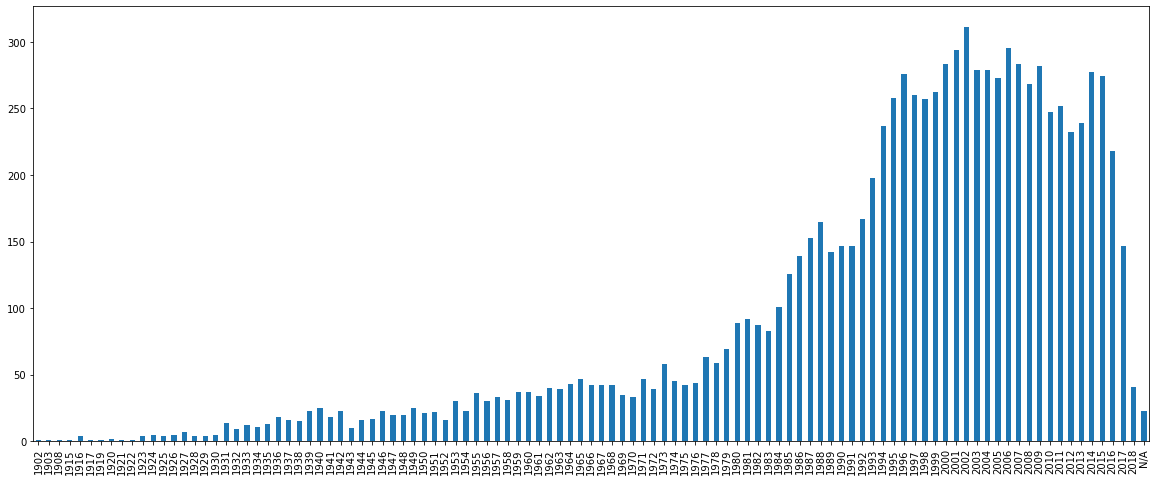

In [0]:
# กราฟที่ 1: แสดงกราฟค่า จำนวน released movies ในแต่ละปี 
movies_df['released'].value_counts().sort_index().plot.bar(figsize=(20,8))

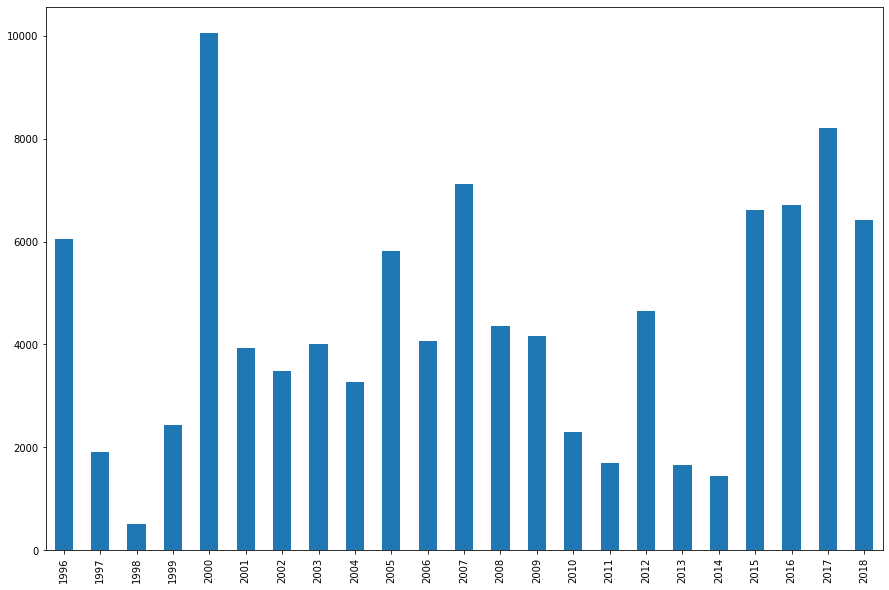

In [0]:
# กราฟที่ 2: แสดงกราฟค่า จำนวนการให้ rating ในแต่ละปี
ratings_df['year'].value_counts().sort_index().plot.bar(figsize=(15,10))

<BarContainer object of 19 artists>

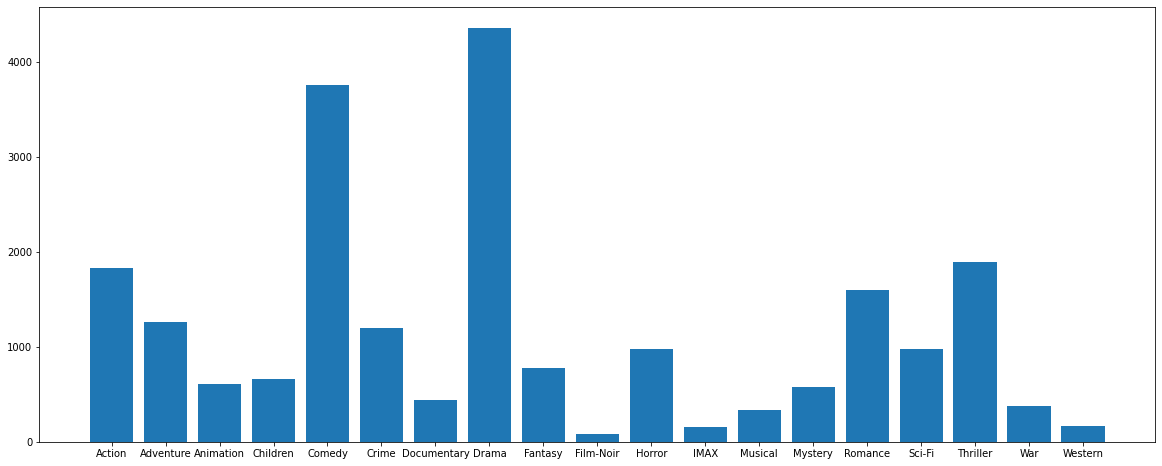

In [0]:
def feature(x):
  genre = []
  values = []
  for i in range(len(x)):
    genre.append(x[i]) 
  for item in genre:
    m = (movies_genre[item] == 1).sum()
    values.append(m)
  return genre, values
genre, values = feature(movies_genre.drop('movieId',axis = 1).columns)

# กราฟที่ 3: แสดงกราฟค่า จำนวน movies ในแต่ละ genre 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(genre, values) 

In [0]:
# กราฟที่ 4: แสดงกราฟ (y-axis: stacked graph) ค่าจำนวน movie แต่ละ genre  ในแต่ละปี (x-axis)
import plotly.express as px

movies_genre['released'] = movies_df['released'].copy()
df_4 = movies_genre.groupby('released').sum().reset_index()
df_4.drop('movieId', axis = 1, inplace = True)
df_4 = df_4.melt('released')
fig = px.bar(df_4, x = 'released', y = 'value', color = 'variable', color_discrete_sequence = px.colors.qualitative.Prism)
fig.show()

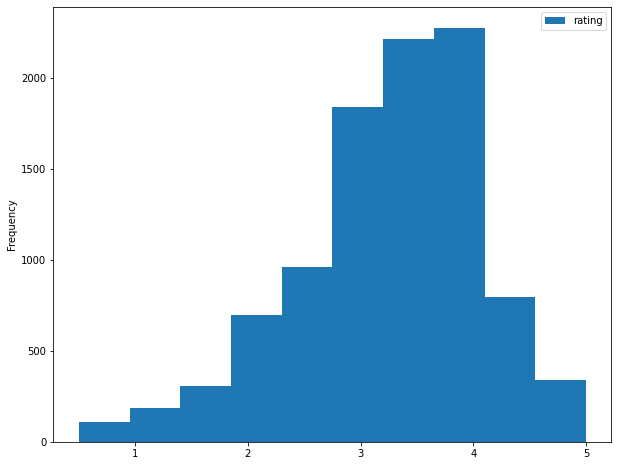

In [0]:
# กราฟที่ 5: แสดงกราฟ Histogram ของการกระจายของค่าเฉลี่ย movie rating
movies_rating = pd.pivot_table(ratings_df, index = ['movieId'], values = ['rating'], aggfunc = np.mean)
movies_rating.plot.hist(figsize=(10, 8))

# ตอนที่ 2 การทดลองสร้างระบบแนะนำสินค้า (Recommendation system) จากข้อมูล user_matrix

In [0]:
# Creating user_matrix
user_matrix = pd.pivot_table(ratings_df, index = 'userId', columns = 'movieId', aggfunc = np.max)
user_matrix.fillna(0, inplace = True)
user_matrix.head(5)

rating                              ...   year                            
movieId 1      2      3      4      5       ... 193581 193583 193585 193587 193609
userId                                      ...                                   
1          4.0    0.0    4.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
2          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
3          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
4          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
5          4.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0

[5 rows x 29172 columns]

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

# 2.2.1 - 2.2.2 cosine similarity of random user_matrix (n = 25)
user_matrix_ran = user_matrix.sample(n = 25, random_state = 1) #, replace = True
cosine_sim = cosine_similarity(user_matrix_ran)

In [0]:
cosine_sim.shape

(25, 25)

In [0]:
# 2.2.3 pearson's similarity of random user_matrix transpose (random item matrix) (n = 25)
pearson_sim = user_matrix_ran.transpose().corr(method = 'pearson')
pearson_simnp = pearson_sim.to_numpy()

In [0]:
pearson_sim.shape

(25, 25)

In [0]:
# gets the top 5 similar, different users
def get_top(x):
  topsim = []
  topdif = []
  for i in range(x.shape[0]):
    for j in range(x.shape[0]):
      if i != j:
        topsim.append((x[i][j], user_matrix_ran.index[i], user_matrix_ran.index[j]))
  topsim = sorted(topsim, reverse = True)
  topdif = sorted(topsim)
  df = pd.DataFrame(topsim)
  df.columns = ['score', 'user1', 'user2']
  df2 = pd.DataFrame(topdif)
  df2.columns = ['score', 'user1', 'user2']
  return df, df2

simc, difc = get_top(cosine_sim)
print('-------------cosine-------------')
print(simc.groupby('score', sort = False)[['user1','user2']].first().reset_index()[:5])
print('-------------pearson-------------')
simp, difp = get_top(pearson_simnp)
print(simp.groupby('score', sort = False)[['user1','user2']].first().reset_index()[:5])
print('-------------pearson-------------')
print(difp.groupby('score')[['user1','user2']].first().reset_index()[:5])


-------------cosine-------------
      score  user1  user2
0  0.435906    121     14
1  0.324350    560    495
2  0.299428    597      1
3  0.297181    599    597
4  0.293444    597     66
-------------pearson-------------
      score  user1  user2
0  0.434888    121     14
1  0.316330    560    495
2  0.291817    597      1
3  0.283877    597     66
4  0.275220    599    597
-------------pearson-------------
      score  user1  user2
0 -0.005558      1    306
1 -0.005226     89    238
2 -0.003694     89    120
3 -0.003308    560    576
4 -0.002771    121    306


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



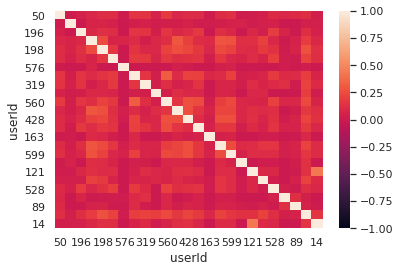

In [0]:
import seaborn as sns; sns.set()

ax = sns.heatmap(pearson_sim, vmin = -1, vmax = 1)

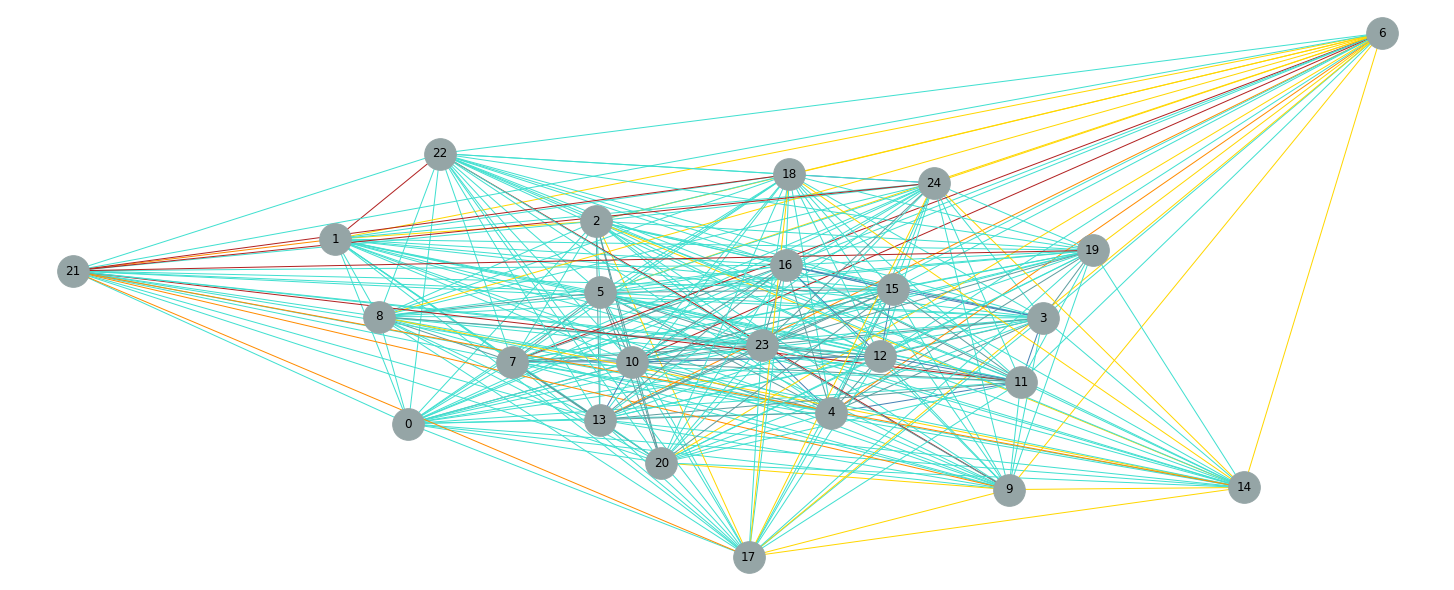

In [0]:
from networkx import nx 
from matplotlib.lines import Line2D 
# 2.4.1

plt.figure(figsize=(20,8))
# Create New Graph 
G = nx.Graph() 

# Create #node = #user ใน Pearson’s similarity และใส่ label เป็น user_id ในแต่ละ node 
for x in range (len(pearson_sim)):      
  G.add_node(x)

# Add Edges with weight and assign color to the lines depend on 3 conditions 
for i in range (len(pearson_sim)):        
  for j in range (len(pearson_sim)):       
    if pearson_sim.index[i] != pearson_sim.columns[j]:         
      if pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]] > 0.25 :                     
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='steelblue')             
      elif pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]] > 0.15 :          
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='cadetblue')
      elif pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]] > 0 :          
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='turquoise')
      elif pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]] > -.0015 :          
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='gold')
      elif pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]] > -.0025 :          
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='darkorange')
      else :        
        G.add_edge(i, j, weight = pearson_sim.loc[pearson_sim.index[i],pearson_sim.columns[j]], color='firebrick')

colors = [G[u][v]['color'] for u,v in G.edges()]
nx.draw(G, with_labels = True, font_color = 'black', node_size = 1000, node_color = '#95A5A6', edge_color = colors)
plt.show()

In [0]:
# 2.4.2
idx = simp.groupby(['user1'])['score'].transform(max) == simp['score']
score_max = simp[idx]
score_max

idx_2 = ratings_df.groupby(['userId'])['rating'].transform(max) == ratings_df['rating']
rating_max = ratings_df[idx_2]

rating_max = rating_max.groupby('userId', sort = False)[['rating','movieId']].first().reset_index()
suggest_df = score_max.merge(rating_max, left_on = 'user2', right_on = 'userId', how = 'left')

suggest_df = suggest_df.merge(movies_df[['movieId','title']], left_on = 'movieId', right_on = 'movieId', how = 'left')
suggest_df.drop(['userId','movieId'], axis = 1, inplace = True)
suggest_df

,score,user1,user2,rating,title
0,0.434888,121,14,5.0,Seven (a.k.a. Se7en)
1,0.434888,14,121,5.0,Heat
2,0.316330,560,495,5.0,"Shawshank Redemption, The"
3,0.316330,495,560,4.5,Léon: The Professional (a.k.a. The Professiona...
4,0.291817,597,1,5.0,Seven (a.k.a. Se7en)
5,0.291817,1,597,5.0,Get Shorty
6,0.283877,66,597,5.0,Get Shorty
7,0.275220,599,597,5.0,Get Shorty
8,0.269045,593,198,5.0,Twelve Monkeys (a.k.a. 12 Monkeys)
9,0.269045,198,593,5.0,Star Wars: Episode IV - A New Hope


In [0]:
# 2.4.3
idx_3 = difp.groupby(['user1'])['score'].transform(min) == difp['score']
score_max = difp[idx_3]
score_max

idx_4 = ratings_df.groupby(['userId'])['rating'].transform(max) == ratings_df['rating']
rating_max = ratings_df[idx_4]

rating_max = rating_max.groupby('userId', sort = False)[['rating','movieId']].first().reset_index()
suggest_df = score_max.merge(rating_max, left_on = 'user2', right_on = 'userId', how = 'left')

suggest_df = suggest_df.merge(movies_df[['movieId','title']], left_on = 'movieId', right_on = 'movieId', how = 'left')
suggest_df.drop(['userId','movieId'], axis = 1, inplace = True)
suggest_df.head(5)

,score,user1,user2,rating,title
0,-0.005558,1,306,5.0,"Lake House, The"
1,-0.005558,306,1,5.0,Seven (a.k.a. Se7en)
2,-0.005226,89,238,5.0,Patton
3,-0.005226,238,89,5.0,Scary Movie
4,-0.003694,120,89,5.0,Scary Movie


# ตอนที่ 3 การทดลองสร้างระบบแนะนำสินค้า (Recommendation system) จากข้อมูล movie_matrix

In [0]:
# cosine similarity of random user_matrix (n = 25)
movie_matrix_ran = movies_genre.sample(n = 25, random_state = 1)
movie_matrix_ran = movie_matrix_ran.drop(['released'], axis = 1)
movie_matrix_ran.set_index('movieId', inplace = True) 
movie_cosine_sim = cosine_similarity(movie_matrix_ran)


In [0]:
# cosine_sim
movie_matrix_ran.head(5)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
53894,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
784,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5348,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4825,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1626,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# pearson's similarity of random user_matrix (n = 25)
movie_pearson_sim = movie_matrix_ran.transpose().corr(method = 'pearson')
movie_pearson_simnp = movie_pearson_sim.to_numpy()
# pearson_simnp

In [0]:
# 3.2.1 - 3.2.2
def get_top_movie(x):
  topsim = []
  topdif = []
  for i in range(x.shape[0]):
    for j in range(x.shape[0]):
      if i != j:
        topsim.append((x[i][j], movie_matrix_ran.index[i], movie_matrix_ran.index[j]))
  topsim = sorted(topsim, reverse = True)
  topdif = sorted(topsim)
  df = pd.DataFrame(topsim)
  df.columns = ['score', 'movie1', 'movie2']
  df2 = pd.DataFrame(topdif)
  df2.columns = ['score', 'movie1', 'movie2']
  return df, df2

movie_simp, movie_difp = get_top_movie(movie_pearson_simnp)
print('-------------pearson-------------')
print(movie_simp.groupby('score', sort = False)[['movie1','movie2']].first().reset_index()[:5])
print('-------------pearson-------------')
print(movie_difp.groupby('score')[['movie1','movie2']].first().reset_index()[:5])

-------------pearson-------------
      score  movie1  movie2
0  1.000000    7879    7647
1  0.792118    5348     319
2  0.792118     784     319
3  0.687184    7477    2179
4  0.687184   59131    7477
-------------pearson-------------
      score  movie1  movie2
0 -0.294174    1464    6239
1 -0.233021    1464   96737
2 -0.233021    1464    6755
3 -0.233021     784    1464
4 -0.223607     724    6239


In [0]:
ratings_df.head(5)

,userId,movieId,rating,timestamp,year
0,1,1,4.0,964982703,2000
1,1,3,4.0,964981247,2000
2,1,6,4.0,964982224,2000
3,1,47,5.0,964983815,2000
4,1,50,5.0,964982931,2000


In [0]:
# 2.4.3

suggest_movie = pd.merge(ratings_df[ratings_df['rating'] >= 3.0], movie_simp[movie_simp['score'] >= 0.75], left_on = 'movieId', right_on = 'movie1').drop(['timestamp', 'year', 'movie1'], axis = 1)
suggest_movie = suggest_movie.merge(movies_df[['movieId','title']], left_on = 'movie2', right_on = 'movieId', how = 'left').drop(['movieId_x', 'movieId_y'], axis = 1).dropna()

In [0]:
suggest_movie

,userId,rating,score,movie2,title
0,4,5.0,0.792118,5348,Hollywood Ending
1,4,5.0,0.792118,4825,"Swamp, The (Ciénaga, La)"
2,4,5.0,0.792118,784,"Cable Guy, The"
3,16,4.0,0.792118,5348,Hollywood Ending
4,16,4.0,0.792118,4825,"Swamp, The (Ciénaga, La)"
...,...,...,...,...,...
94,318,3.0,1.000000,5348,Hollywood Ending
95,318,3.0,0.792118,319,Shallow Grave
96,474,3.0,1.000000,540,Sliver
97,477,4.0,1.000000,4825,"Swamp, The (Ciénaga, La)"


# ตอนที่ 4 การจัดกลุ่ม User ที่มีความชอบคล้ายกันด้วยเทคนิค k-mean และ Gaussian Mixture

In [0]:
# create genre_rating_matrix
genre_rating = pd.merge(ratings_df[['userId', 'movieId', 'rating']], movies_genre.drop(columns = ['released']), left_on='movieId', right_on='movieId')
genre_rating = genre_rating.melt(['userId','rating'])
genre_rating = genre_rating[genre_rating['value'] == 1].groupby(['userId','variable'])[['rating']].mean()
genre_rating_matrix = pd.pivot_table(genre_rating, index = 'userId', columns = 'variable', values = 'rating')
genre_rating_matrix.fillna(0, inplace = True)
genre_rating_matrix.drop(columns = ['movieId'])

variable,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.000000,4.529412,4.297872,5.0000,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714
2,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.333333,3.882353,0.000000,0.0000,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000
3,3.571429,2.727273,0.500000,0.500000,1.000000,0.500000,0.000000,0.750000,3.375000,0.0000,4.687500,0.000000,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000
4,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.000000,3.483333,3.684211,4.0000,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000
5,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.000000,3.800000,4.142857,0.0000,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.178808,3.503401,3.714286,3.448980,3.565321,3.654135,3.800000,3.787966,3.597938,3.8125,3.346154,3.062500,3.727273,3.791209,3.740845,3.556962,3.525126,3.792308,3.411765
607,3.722222,3.466667,3.333333,3.421053,3.327273,3.814815,0.000000,4.012195,3.571429,0.0000,4.114286,5.000000,3.600000,4.647059,3.517241,3.250000,4.114754,4.166667,4.000000
608,3.330325,3.220994,3.118182,2.460227,2.736620,3.613014,3.000000,3.437500,3.000000,3.7500,3.319588,4.000000,2.757576,3.550725,2.886792,3.296407,3.536680,3.578947,2.636364


In [0]:
genre_rating_matrix

variable,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
userId,,,,,,,,,,,,,,,,,,,,
1,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.000000,4.529412,4.297872,5.0000,3.470588,0.000000,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714,4.0
2,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.333333,3.882353,0.000000,0.0000,3.000000,3.750000,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000,0.0
3,3.571429,2.727273,0.500000,0.500000,1.000000,0.500000,0.000000,0.750000,3.375000,0.0000,4.687500,0.000000,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000,0.0
4,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.000000,3.483333,3.684211,4.0000,4.250000,3.000000,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000,0.0
5,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.000000,3.800000,4.142857,0.0000,3.000000,3.666667,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.178808,3.503401,3.714286,3.448980,3.565321,3.654135,3.800000,3.787966,3.597938,3.8125,3.346154,3.062500,3.727273,3.791209,3.740845,3.556962,3.525126,3.792308,3.411765,2.5
607,3.722222,3.466667,3.333333,3.421053,3.327273,3.814815,0.000000,4.012195,3.571429,0.0000,4.114286,5.000000,3.600000,4.647059,3.517241,3.250000,4.114754,4.166667,4.000000,4.0
608,3.330325,3.220994,3.118182,2.460227,2.736620,3.613014,3.000000,3.437500,3.000000,3.7500,3.319588,4.000000,2.757576,3.550725,2.886792,3.296407,3.536680,3.578947,2.636364,2.5


In [0]:
# train_test_split module
# take 80% as the training set and 20% as the test set
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

X_train, X_test = train_test_split(genre_rating_matrix, test_size = .2, random_state = 42)
X_train, X_valid = train_test_split(X_train, test_size = .2, random_state = 42)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

kmeans3 = KMeans(n_clusters = 3)
kmeans4 = KMeans(n_clusters = 4)
kmeans5 = KMeans(n_clusters = 5)

user_kmeans3 = kmeans3.fit(X_train)
user_pred3 = kmeans3.predict(X_valid)
centroids3 = kmeans3.cluster_centers_

user_kmeans4 = kmeans4.fit(X_train)
user_pred4 = kmeans4.predict(X_valid)
centroids4 = kmeans4.cluster_centers_

user_kmeans5 = kmeans5.fit(X_train)
user_pred5 = kmeans5.predict(X_valid)
centroids5 = kmeans5.cluster_centers_

# centroids3
# user_pred
# X_train

(390, 20)
(98, 20)
(122, 20)


variable,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
userId,,,,,,,,,,,,,,,,,,,,
217,2.841004,2.948276,3.115385,2.786667,2.639073,2.885057,0.00,2.838323,2.676056,3.00,2.760000,0.000000,2.800000,3.062500,2.594595,2.911765,2.918750,2.620690,2.428571,4.0
488,3.500000,4.369565,4.233333,4.088235,3.938596,4.136364,4.25,3.712963,4.125000,3.25,4.166667,4.375000,3.833333,3.500000,3.890625,3.750000,3.928571,4.100000,4.000000,4.5
93,4.326087,4.196429,3.750000,4.058824,4.111111,4.375000,0.00,4.500000,4.263158,0.00,4.333333,5.000000,4.000000,4.500000,4.347826,4.500000,4.363636,5.000000,4.000000,3.0
60,4.000000,3.500000,3.500000,3.400000,3.500000,4.000000,0.00,3.933333,3.000000,0.00,0.000000,5.000000,3.500000,3.500000,3.400000,0.000000,3.500000,4.000000,0.000000,0.0
315,3.000000,3.142857,3.000000,3.000000,3.375000,4.000000,0.00,3.777778,3.333333,0.00,2.333333,0.000000,3.200000,0.000000,4.000000,2.600000,2.333333,3.666667,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,3.714286,4.423077,4.000000,4.000000,4.714286,3.833333,0.00,4.166667,4.500000,0.00,3.400000,3.500000,0.000000,2.875000,4.285714,3.791667,3.916667,4.750000,0.000000,4.0
401,3.562500,3.563830,3.576923,3.585106,3.488372,3.500000,0.00,3.576923,3.534483,0.00,4.500000,3.576923,3.500000,3.500000,3.593750,3.772727,4.250000,3.500000,3.500000,3.5
510,2.571429,2.941176,3.500000,3.166667,2.883721,3.041667,4.00,2.951923,2.777778,4.00,2.200000,4.000000,3.500000,2.541667,2.947368,2.272727,2.500000,3.900000,2.166667,0.0


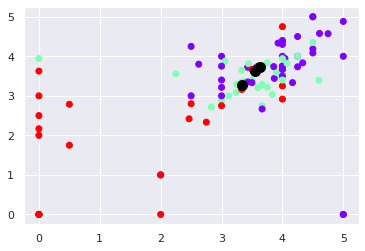

In [0]:
plt.scatter(X_valid['Animation'], X_valid['Fantasy'], c = user_pred3, cmap = 'rainbow')
plt.scatter(pd.DataFrame(centroids3)[0], pd.DataFrame(centroids3)[1], c = 'black' , s = 100)
plt.show()

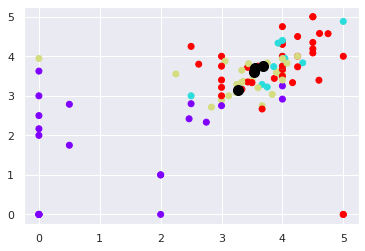

In [0]:
plt.scatter(X_valid['Animation'], X_valid['Fantasy'], c = user_pred4, cmap = 'rainbow')
plt.scatter(pd.DataFrame(centroids4)[0], pd.DataFrame(centroids4)[1], c = 'black' , s = 100)
plt.show()

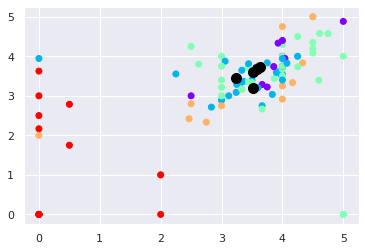

In [0]:
plt.scatter(X_valid['Animation'], X_valid['Fantasy'], c = user_pred5, cmap = 'rainbow')
plt.scatter(pd.DataFrame(centroids5)[0], pd.DataFrame(centroids5)[1], c = 'black' , s = 100)
plt.show()

In [0]:
from sklearn.mixture import GaussianMixture

gmm3 = GaussianMixture(n_components = 3, covariance_type = 'full', random_state = 42)
gmm4 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 42) 
gmm5 = GaussianMixture(n_components = 5, covariance_type = 'full', random_state = 42) 



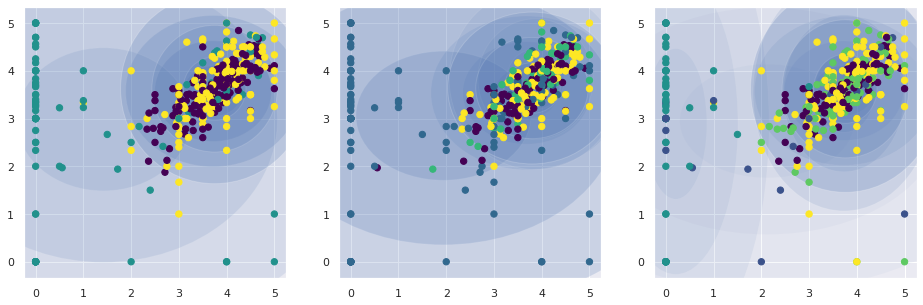

In [0]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

def plot_gmm(gmm, X, dim1, dim2, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X.iloc[:, dim1], X.iloc[:, dim2], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, dim1], X.iloc[:, dim2], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for posX, posY, covar, w in zip(gmm.means_[:, dim1], gmm.means_[:, dim2], gmm.covariances_, gmm.weights_):
        pos = [posX, posY]
        covar = covar[[dim1, dim2], [dim1, dim2]]
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    gmm = GaussianMixture(3+i, covariance_type='full', random_state=42)
    gmm.fit(X_train)
    plot_gmm(gmm, X_train, 2, 8, ax=axes[i])
